<a href="https://colab.research.google.com/github/sayakpaul/Handwriting-Recognizer-in-Keras/blob/main/Initial_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference
- Keras example on [Captcha OCR](https://keras.io/examples/vision/captcha_ocr/)

In [ ]:
!nvidia-smi

Sun Sep 27 04:03:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset collection

In [ ]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip

In [ ]:
!mkdir data
!mkdir data/words
!tar -xf words.tgz -C data/words
!mv words.txt data

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Imports

In [ ]:
from imutils import paths
from tqdm.notebook import tqdm
from pickle import dump
from itertools import groupby

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset preparation

In [ ]:
# filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
all_images = list(paths.list_images('/content/data/words'))
all_images[:5]

['/content/data/words/c04/c04-110/c04-110-00-11.png',
 '/content/data/words/c04/c04-110/c04-110-03-02.png',
 '/content/data/words/c04/c04-110/c04-110-01-03.png',
 '/content/data/words/c04/c04-110/c04-110-03-12.png',
 '/content/data/words/c04/c04-110/c04-110-03-04.png']

In [ ]:
words_list = []

words = open('/content/data/words.txt', 'r').readlines()
for line in tqdm(words):
    if line[0]=='#':
        continue
    if line.split(" ")[1]!="err": # We don't need to deal with errored entries
        words_list.append(line)

len(words_list)

96456

In [ ]:
np.random.shuffle(words_list)

### Prepare the splits (90:10)

In [ ]:
splitIdx = int(0.9 * len(words_list))
trainSamples = words_list[:splitIdx]
validationSamples = words_list[splitIdx:]

len(trainSamples), len(validationSamples)

(86810, 9646)

In [ ]:
train_words = [line.split(' ')[8:][0].strip() for line in trainSamples]
max_label_len = max([len(str(text)) for text in train_words])
print(max_label_len)

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="\n", char_level=True)
tokenizer.fit_on_texts(train_words)
tokenized_words = tokenizer.texts_to_sequences(train_words)
padded_train_words = tf.keras.preprocessing.sequence.pad_sequences(tokenized_words,
                                                        maxlen=max_label_len,
                                                        padding='post',
                                                        value=99)

# maximum sequence length is 4, hence a word is padded to that length
padded_train_words.shape, padded_train_words[0]

21


((86810, 21),
 array([ 7, 13,  8,  1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99, 99], dtype=int32))

In [ ]:
# unique characters
len(tokenizer.word_index)

52

In [ ]:
# view some integer mappings
def process_word(word):
    processed_word = []
    for i in word:
        if i != 99:
            processed_word.append(tokenizer.index_word[i])
    return "".join(processed_word)

def view_sample_mappings(sample_padded_words):
    for t in sample_padded_words:
        word = process_word(t)
        print (f"{t.tolist()}----> {word}")

In [ ]:
view_sample_mappings(padded_train_words[:50])

[7, 13, 8, 1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> sure
[9, 1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> he
[11, 13, 8, 5, 6, 17, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> during
[4, 15, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> of
[20, 4, 4, 2, 19, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> booty
[17, 3, 7, 2, 8, 4, 6, 4, 14, 19, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> gastronomy
[20, 4, 19, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> boy
[2, 9, 1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> the
[3, 6, 11, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> and
[5, 6, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> in
[9, 5, 7, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,

In [ ]:
valid_words = [line.split(' ')[8:][0].strip() for line in validationSamples]
tokenized_valid_words = tokenizer.texts_to_sequences(valid_words)
padded_valid_words = tf.keras.preprocessing.sequence.pad_sequences(tokenized_valid_words,
                                                        maxlen=max_label_len,        
                                                        padding='post',
                                                        value=99)
padded_valid_words.shape, padded_valid_words[0]

((9646, 21),
 array([ 3, 20, 10,  1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99, 99, 99], dtype=int32))

In [ ]:
view_sample_mappings(padded_valid_words[:50])

[3, 20, 10, 1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> able
[15, 13, 10, 10, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> full
[21, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> .
[3, 12, 2, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> act
[19, 4, 13, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> you
[6, 3, 2, 5, 4, 6, 3, 10, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> national
[26, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> -
[3, 20, 19, 7, 7, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> abyss
[7, 3, 5, 11, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> said
[5, 6, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> in
[3, 23, 5, 3, 2, 5, 4, 6, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9

In [ ]:
 # Credit: https://github.com/githubharald/SimpleHTR/blob/master/src/SamplePreprocessor.py
 def distortion_free_resize(img, imgSize):
    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize)
    target = np.ones([ht, wt]) * 255
    target[0:newSize[1], 0:newSize[0]] = img

    # transpose for TF
    img = cv2.transpose(target)

    return img

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 32

def process_images(img_path, imgSize=(IMG_WIDTH, IMG_HEIGHT)):    
    # read image in grayscale mode
    image = cv2.imread(img_path, 0)
    # scale pixel values to [0, 1]
    image = image.astype("float32")/255
    # resize image
    image = distortion_free_resize(image, imgSize)
    image = np.expand_dims(image, axis=-1) # Add channel otherwise Conv2D won't be compatible

    return image

In [ ]:
train_images = np.zeros(shape=(len(trainSamples), IMG_WIDTH, IMG_HEIGHT, 1))
for (i, file_line) in enumerate(tqdm(trainSamples)):
    lineSplit = file_line.strip()
    lineSplit = lineSplit.split(" ")
    # part1/part1-part2/part1-part2-part3.png
    imageName = lineSplit[0] 
    partI = imageName.split("-")[0]
    partII = imageName.split("-")[1]
    img_path =  os.path.join("/content/data/words/", partI, 
                partI + '-' + partII,
                imageName + ".png"
    )
    if os.path.getsize(img_path)!=0:
        preprocessed_image = process_images(img_path)
    
    train_images[i] = preprocessed_image

train_images.shape

(86810, 128, 32, 1)

In [ ]:
validation_images = np.zeros(shape=(len(validationSamples), IMG_WIDTH, IMG_HEIGHT, 1))
for (i, file_line) in enumerate(tqdm(validationSamples)):
    lineSplit = file_line.strip()
    lineSplit = lineSplit.split(" ")
    # part1/part1-part2/part1-part2-part3.png
    imageName = lineSplit[0] 
    partI = imageName.split("-")[0]
    partII = imageName.split("-")[1]
    img_path =  os.path.join("/content/data/words/", partI, 
                partI + '-' + partII,
                imageName + ".png"
    )
    if os.path.getsize(img_path)!=0:
        preprocessed_image = process_images(img_path)
    
    validation_images[i] = preprocessed_image

validation_images.shape

(9646, 128, 32, 1)

In [ ]:
# Construct TensorFlow datasets

BS = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

def make_dicts(image, label):
    return {"image": image, "label": label}

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, padded_train_words))
train_dataset = (train_dataset
    .shuffle(1024)
    .map(make_dicts, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, padded_valid_words))
validation_dataset = (validation_dataset
    .map(make_dicts, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

In [ ]:
def plot_samples(images, labels):
    _, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = process_word(labels[i].numpy())
        ax[i // 4, i % 4].imshow(img.squeeze(-1).T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    plt.show()

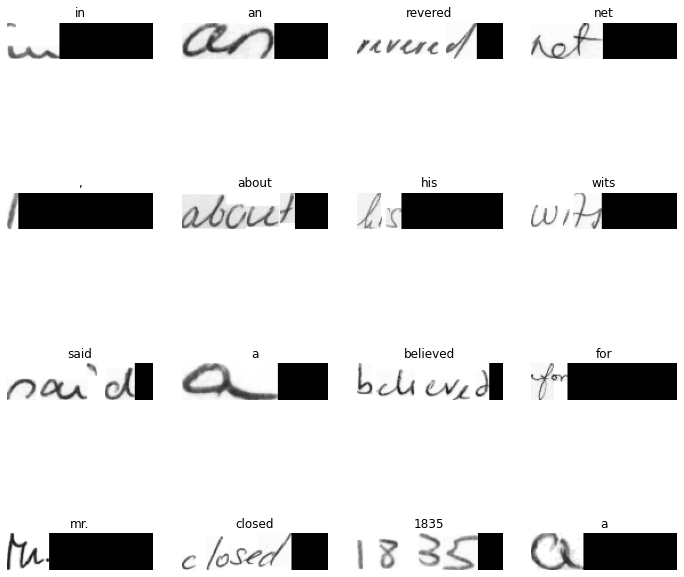

In [ ]:
batch = next(iter(train_dataset))
plot_samples(batch["image"], batch["label"])

In [ ]:
batch["image"].shape, batch["label"].shape

(TensorShape([64, 128, 32, 1]), TensorShape([64, 21]))

In [ ]:
tokenizer.index_word[52]

'*'

## Model building

In [ ]:
class CTCLayer( tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        # y_true = tf.cast(y_true, tf.float32)
        # y_pred = tf.cast(y_pred, tf.float32)
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img =  tf.keras.layers.Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")
    labels =  tf.keras.layers.Input(name="label", shape=(None,))

    # First conv block
    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x =  tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x =  tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x =  tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x =  tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x =  tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x =  tf.keras.layers.Dropout(0.2)(x)

    # RNNs
    x =  tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x =  tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer (the tokenizer is char-level)
    # +2 recommendation came from here - https://github.com/MaybeShewill-CV/CRNN_Tensorflow/issues/69#issuecomment-383992527
    x =  tf.keras.layers.Dense(len(tokenizer.word_index) + 2, activation="softmax", name="dense2")(x)
    
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model =  tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = tf.keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 32, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 16, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 16, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

In [ ]:
# Run a dummy set of samples through the CTC loss
outputs = model([batch["image"], batch["label"]])
print(outputs.shape)

batch_len = tf.cast(tf.shape(batch["label"])[0], dtype="int64")
input_length = tf.cast(tf.shape(outputs)[1], dtype="int64")
label_length = tf.cast(tf.shape(batch["label"])[1], dtype="int64")

input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

print(tf.keras.backend.ctc_batch_cost(batch["label"], outputs, input_length, label_length).shape)

(64, 32, 54)
(64, 1)


## Model training

In [ ]:
epochs = 100
early_stopping_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
model = build_model()
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
1357/1357 [==============================] - 75s 55ms/step - loss: 12.8547 - val_loss: 10.7324
Epoch 2/100
1357/1357 [==============================] - 73s 54ms/step - loss: 9.9816 - val_loss: 9.1448
Epoch 3/100
1357/1357 [==============================] - 75s 55ms/step - loss: 8.8444 - val_loss: 7.9497
Epoch 4/100
1357/1357 [==============================] - 74s 54ms/step - loss: 7.9073 - val_loss: 7.0442
Epoch 5/100
1357/1357 [==============================] - 71s 53ms/step - loss: 7.1840 - val_loss: 6.3452
Epoch 6/100
1357/1357 [==============================] - 73s 54ms/step - loss: 6.5705 - val_loss: 5.8407
Epoch 7/100
1357/1357 [==============================] - 73s 54ms/step - loss: 6.1708 - val_loss: 5.4441
Epoch 8/100
1357/1357 [==============================] - 74s 55ms/step - loss: 5.8599 - val_loss: 5.2326
Epoch 9/100
1357/1357 [==============================] - 73s 53ms/step - loss: 5.6290 - val_loss: 5.0546
Epoch 10/100
1357/1357 [=============================

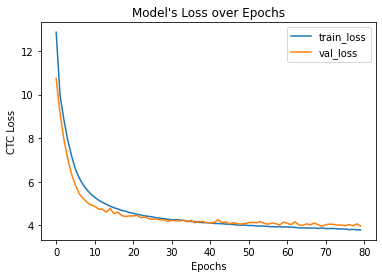

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("CTC Loss")
plt.title("Model's Loss over Epochs")
plt.legend()
plt.show()

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 32, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 32, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 16, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 64, 16, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 8, 64)         0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 512)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 64)           

In [ ]:
# Reference: https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(tokenizer.index_word) + 1:
                ans += tokenizer.index_word[int(p)]
        
        text_list.append(ans)
        
    return text_list

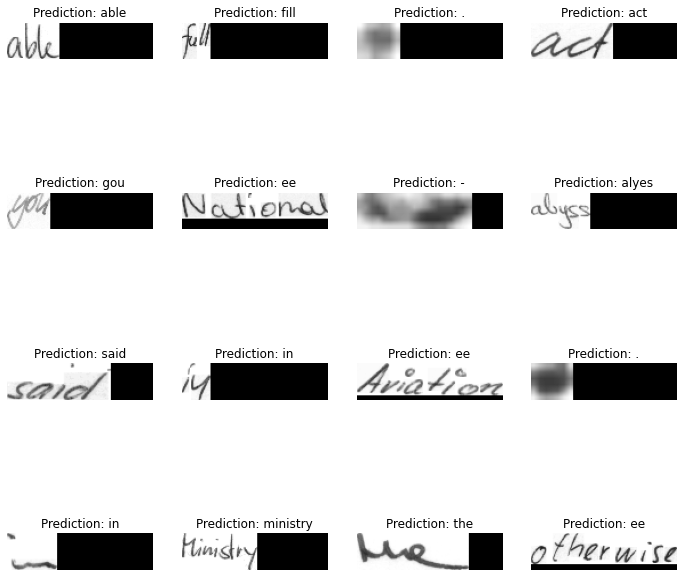

In [ ]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    fig , ax = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(16):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img.T, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()